In [1]:
import os
import re
import pandas as pd

def extract_job_line_parameters(line):
    params = re.findall(r"--\w+ \S+", line)
    params_dict = {}
    for param in params:
        key, value = param.split(" ")
        key = key[2:]
        params_dict[key] = value
    return params_dict

In [2]:

# Collect all CSV files from the results folder
results_folder = "results/ENZYMES/"
csv_files = [os.path.join(results_folder, f) for f in os.listdir(results_folder) if f.endswith(".csv")]

# Combine all CSVs into a single DataFrame
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    config_id = int(os.path.splitext(os.path.basename(csv_file))[0])
    df['config_id'] = config_id
    dfs.append(df)
all_results = pd.concat(dfs, ignore_index=True)

# Compute mean and standard error within the group of cross-validation folds for each model
agg_results = all_results.groupby('config_id').agg(
    {'train_accuracy': ['mean', 'std'], 'validation_accuracy': ['mean', 'std'], 'training_time': ['mean', 'std']}
)
agg_results.columns = ['_'.join(col).strip() for col in agg_results.columns.values]
agg_results = agg_results.reset_index()

agg_results.sort_values(by='validation_accuracy_mean', ascending=False, inplace=True)
agg_results.set_index('config_id', inplace=True)
# Save aggregated results to a new CSV
agg_results.to_csv("aggregated_results.csv")

# Check for missing config_ids
max_config_id = max(all_results['config_id'])
missing_config_ids = sorted(set(range(1, max_config_id + 1)) - set(all_results['config_id']))

# Read existing job.txt file
with open("job.txt", "r") as f:
    job_lines = f.readlines()

# Extract configurations from job lines
configs = []
for line in job_lines:
    params_dict = extract_job_line_parameters(line)
    config_id = int(params_dict.pop("config_id"))
    configs.append((config_id, params_dict))

# Create a DataFrame of configurations with config_id as the index
configs_df = pd.DataFrame.from_records(configs, index='config_id', columns=['config_id', 'params'])
configs_df = configs_df['params'].apply(pd.Series)

# Check if the configurations.csv file exists
if os.path.exists("configurations.csv"):
    # Read the existing configurations from the CSV file
    existing_configs = pd.read_csv("configurations.csv", index_col="config_id")
    # Append the new configurations to the existing ones
    new_indices = configs_df.index.difference(existing_configs.index)
    configs_df = existing_configs.append(configs_df.loc[new_indices])

configs_df = configs_df.loc[agg_results.index, :]
# Save configurations DataFrame to a CSV file
configs_df.to_csv("configurations.csv")

# Concatenate the two DataFrames side-by-side
full_results = pd.concat([agg_results, configs_df], axis=1)

# Save the concatenated DataFrame to a CSV file
full_results.to_csv("full_results.csv")


# Generate new job lines for missing config_ids
new_job_lines = []
for missing_id in missing_config_ids:
    for line in job_lines:
        if line.startswith(f"/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/bin/python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/Graph_expressivity/ablation/train_and_evaluate.py --config_id {missing_id}"):
            new_job_lines.append(line)
            break

# Write new job lines to a new_jobs.txt file
with open("new_jobs.txt", "w") as f:
    for line in new_job_lines:
        f.write(line)


In [3]:
configs_df

,pde_type,time_points,time_range,num_pde_layers,num_lin_layers_between,num_lin_layers_after,hidden_units,learning_rate
config_id,,,,,,,,
623,heat,10,4.0,2,1,1,128,0.001
639,heat,20,4.0,2,1,1,128,0.001
663,heat,40,8.0,2,1,1,128,0.001
659,heat,40,4.0,1,1,1,128,0.001
667,heat,40,8.0,1,1,1,128,0.001
...,...,...,...,...,...,...,...,...
24,heat,1,1.0,2,2,1,32,0.001
344,wave,1,4.0,2,2,1,32,0.001
572,wave,100,8.0,2,2,2,32,0.001


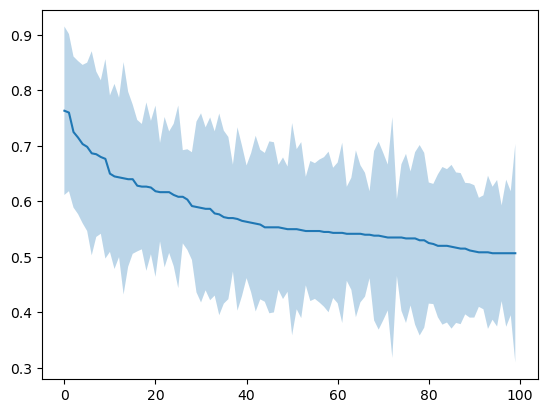

In [4]:
import matplotlib.pyplot as plt

# Extract the mean and standard error data
mean = full_results.iloc[:100, :].validation_accuracy_mean.to_numpy()
std_error = full_results.iloc[:100, :].validation_accuracy_std.to_numpy()

# Define the x-axis values
x = range(len(mean))

# Plot the curve
plt.plot(x, mean)

# Add the shaded region for the standard error
plt.fill_between(x, mean - std_error, mean + std_error, alpha=0.3)

# Display the plot
plt.show()


In [5]:
full_results.iloc[:20, :]

,train_accuracy_mean,train_accuracy_std,validation_accuracy_mean,validation_accuracy_std,training_time_mean,training_time_std,pde_type,time_points,time_range,num_pde_layers,num_lin_layers_between,num_lin_layers_after,hidden_units,learning_rate
config_id,,,,,,,,,,,,,,
623,0.802083,0.091584,0.763333,0.151795,145.378496,1.896119,heat,10,4.0,2,1,1,128,0.001
639,0.812083,0.084142,0.760000,0.141593,1623.799861,19.535569,heat,20,4.0,2,1,1,128,0.001
663,0.754583,0.099700,0.725000,0.136040,1063.142228,12.013622,heat,40,8.0,2,1,1,128,0.001
659,0.748750,0.096123,0.715000,0.137866,233.395700,2.429511,heat,40,4.0,1,1,1,128,0.001
667,0.736667,0.092334,0.703333,0.142595,242.234626,2.550609,heat,40,8.0,1,1,1,128,0.001
647,0.807500,0.095670,0.698333,0.151658,192.466863,1.381746,heat,20,8.0,2,1,1,128,0.001
591,0.708750,0.159395,0.686667,0.183863,348.713449,5.091167,wave,20,4.0,2,1,1,128,0.001
643,0.722917,0.102179,0.685000,0.149001,152.279140,1.527829,heat,20,4.0,1,1,1,128,0.001
641,0.696250,0.076183,0.680000,0.138268,108.996975,1.311121,heat,20,4.0,2,1,1,64,0.001


In [6]:
import numpy as np
res = np.round(full_results.iloc[:5, :], 4)

In [7]:
res.train_accuracy_mean *= 100
res.validation_accuracy_mean *= 100
res.train_accuracy_std *= 100
res.validation_accuracy_std *= 100
res

,train_accuracy_mean,train_accuracy_std,validation_accuracy_mean,validation_accuracy_std,training_time_mean,training_time_std,pde_type,time_points,time_range,num_pde_layers,num_lin_layers_between,num_lin_layers_after,hidden_units,learning_rate
config_id,,,,,,,,,,,,,,
623,80.21,9.16,76.33,15.18,145.3785,1.8961,heat,10,4.0,2,1,1,128,0.001
639,81.21,8.41,76.00,14.16,1623.7999,19.5356,heat,20,4.0,2,1,1,128,0.001
663,75.46,9.97,72.50,13.60,1063.1422,12.0136,heat,40,8.0,2,1,1,128,0.001
659,74.88,9.61,71.50,13.79,233.3957,2.4295,heat,40,4.0,1,1,1,128,0.001
667,73.67,9.23,70.33,14.26,242.2346,2.5506,heat,40,8.0,1,1,1,128,0.001


In [8]:
full_results[full_results.pde_type == 'wave'].iloc[:20, :]

,train_accuracy_mean,train_accuracy_std,validation_accuracy_mean,validation_accuracy_std,training_time_mean,training_time_std,pde_type,time_points,time_range,num_pde_layers,num_lin_layers_between,num_lin_layers_after,hidden_units,learning_rate
config_id,,,,,,,,,,,,,,
591,0.708750,0.159395,0.686667,0.183863,348.713449,5.091167,wave,20,4.0,2,1,1,128,0.001
575,0.725417,0.141907,0.641667,0.209248,2157.486853,23.821397,wave,10,4.0,2,1,1,128,0.001
595,0.687083,0.132847,0.640000,0.157608,302.806982,2.985846,wave,20,4.0,1,1,1,128,0.001
619,0.663333,0.079024,0.625000,0.120185,198.602926,2.001307,wave,40,8.0,1,1,1,128,0.001
603,0.634583,0.136690,0.588333,0.170335,302.666087,2.971718,wave,20,8.0,1,1,1,128,0.001
577,0.593333,0.133247,0.586667,0.164633,536.990753,5.573323,wave,10,4.0,2,1,1,64,0.001
579,0.623750,0.151028,0.576667,0.181659,57.556677,0.889953,wave,10,4.0,1,1,1,128,0.001
597,0.570000,0.097010,0.563333,0.101482,56.445218,1.911249,wave,20,4.0,1,1,1,64,0.001
499,0.505000,0.091211,0.550000,0.191213,2484.366150,28.968728,wave,100,1.0,2,1,1,64,0.0001
